In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers tokenizers Datasets
!pip install contractions
!pip install sentencepiece

Mounted at /content/drive
     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 72.8 MB/s 
     |████████████████████████████████| 325 kB 85.3 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 895 kB 84.7 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
     |████████████████████████████████| 136 kB 82.7 MB/s 
     |████████████████████████████████| 1.1 MB 76.0 MB/s 
     |████████████████████████████████| 212 kB 83.9 MB/s 
     |████████████████████████████████| 127 kB 85.0 MB/s 
     |████████████████████████████████| 271 kB 92.5 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 88.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: Py

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 내부 모듈 구현

입력 데이터 → [ batch_size x length ]  
Source & Target Embedding → [ batch_size x length x d_emb ]  
Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.  
Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.  
Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]  
Masking for Masked Attention  
Scaled Dot Product Attention  
Combine Heads →[ batch_size x length x d_emb ]  
Residual Connection  
Layer Normalization  
Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]  
Output Linear Layer → [ batch_size x length x vocab_size ]  

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re, os, io, time, random, seaborn

## Positional Encoding  
![image.png](attachment:image.png)

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

## Multi-Head Attention  
![image.png](attachment:image.png)

Multi-Head Attention은 여러 서브 모듈 결합으로 완성됨  
Embedding된 입력을 Head 수로 분할하는 split_heads(), 분할된 입력에서 Attention 값을 구하는 scaled_dot_product_attention(), 연산 종료 후 분할된 Head를 다시 하나로 결합 시켜주는 combine_heads()까지 MultiHeadAttention 클래스에 정의 후 포함

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        """scaled QK 값 구하기"""
        
        # scaled_qk: Attention를 위한 softmax 직전 scaled QK
        if mask is not None: scaled_qk += (mask * -1e9)
            
        """
            1. Attention Weights 값 구하기 -> attentions
            2. Attention 값을 V에 곱하기 -> out
        """
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
            
        return out, attentions
        
    def split_heads(self, x):
        
        """
        Embedding을 Head의 수로 분할하는 함수
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        
        return split_x
    
    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights
        

## Position-wise Feed-Forward Network  
![image.png](attachment:image.png)

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
    
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        
        return out

# 모듈 조립

## Encoder 레이어 구현

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

Tranasformer Normalization Layer의 위치에 대한 논의  
[Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는  
[Input] - [Norm] - [Module] - [Residual] 방식을 사용  

참조링크 https://arxiv.org/pdf/2002.04745.pdf


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out,mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                          for _ in range(n_layers)]
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

# Transaformer 완성하기  

In [ ]:
# class Transformer(tf.keras.Model):
#     def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size,tgt_vocab_size,
#                 pos_len, dropout=0.2, shared=True):
#         super(Transformer, self).__init__()
#         self.d_model = tf.cast(d_model. tf.float32)
        
#         self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
#         self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
#         self.pos_encoding = positional_encoding(pos_len, d_model)
#         self.dropout = tf.keras.layers.Dropout(dropout)
        
#         self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
#         self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
#         self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
#         self.shared = shared
        
#         if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
    
#     def embedding(self, emb, x):
#         seq_len = x.shape[1]
#         out = emb(x)
        
#         if self.shared: out*= tf.math.sqrt(self.d_model)
            
#         out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
#         out = self.dropout(out)
        
#         return out
    
#     def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
#         enc_in = self.embedding(self.enc_emb, enc_in)
#         dec_in = self.embedding(self.dec_emb, dec_in)
        
#         enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
#         dec_out, dec_attns, dec_enc_attns = \
#         self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
#         logits = self.fc(dec_out)
        
#         return logits, enc_attns, dec_attns, dec_enc_attns

## Masking

generate_paddingmask()는 Attention 할 때 <PAD> 토큰에 Attention 주는 것을 방지

In [ ]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1-np.cumsum(np.eye(src_len, tgt_len),0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)
    
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)
    
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    
    return enc_mask, dec_enc_mask, dec_mask

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


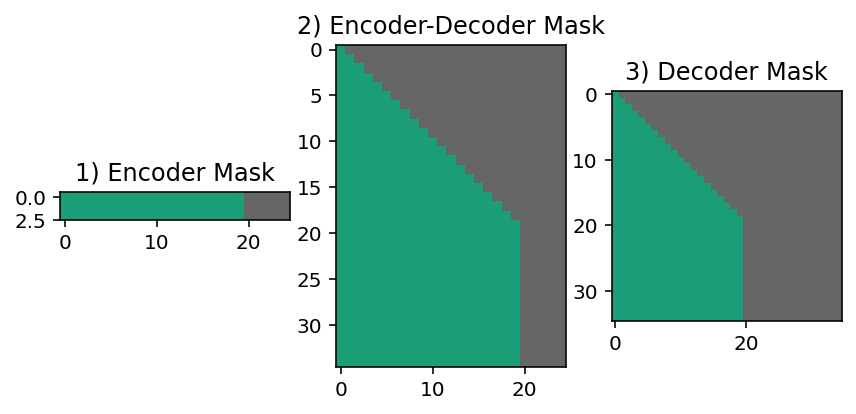

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫번쨰 마스크는 각 배치별로 데이터 꼬리 부분을 Masking,  
두 세번째는 Causality Mask, Padding Mask를 결합한 형태

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_mdoel ** -0.5) * tf.math.minumun(arg1, arg2)
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Text PreProcess

In [4]:
import pandas as pd
from tokenizers import Tokenizer
from tokenizers.models import BPE
df = pd.read_excel('/content/drive/MyDrive/ko_en_data.xlsx')

In [5]:
text_df = df[['원문','번역문']]
text_df.rename(columns={"원문":"ko","번역문":"en"},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
text_df.head()

,ko,en
0,스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.,Skinner's reward is mostly eye-watering.
1,심지어 어떤 문제가 발생할 건지도 어느 정도 예측이 가능하다.,Even some problems can be predicted.
2,오직 하나님만이 그 이유를 제대로 알 수 있을 겁니다.,Only God will exactly know why.
3,중국의 논쟁을 보며 간과해선 안 될 게 기업들의 고충이다.,Businesses should not overlook China's dispute.
4,박자가 느린 노래는 오랜 시간이 지나 뜨는 경우가 있다.,Slow-beating songs often float over time.


In [7]:
import re
import contractions
from tqdm import tqdm
tqdm.pandas()
def ko_preprocess(text):
    text = contractions.fix(text)
    text = re.sub(r"([?.!,])", r" \1", text)
    text = re.sub('[" "]+'," ", text)
    text = re.sub("[^a-zA-Z가-힣ㄱ-ㅎ0-9!,.?]"," ", text)
    return text

def en_preprocess(text):
    text = contractions.fix(text)
    text = re.sub(r"([?.!,])", r" \1", text)
    text = re.sub('[" "]+'," ", text)
    text = re.sub("[^a-zA-Z가-힣ㄱ-ㅎ0-9!,.?]"," ", text)
    text = "<s> " + text + " </s>"
    return text

In [8]:
text_df['ko_prepro'] = text_df.ko.progress_apply(ko_preprocess)
text_df['en_prepro'] = text_df.en.progress_apply(en_preprocess)

100%|██████████| 200011/200011 [00:04<00:00, 48168.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 200011/200011 [00:07<00:00, 25916.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Sentence Piece Tokenizer

In [13]:
from tokenizers import SentencePieceBPETokenizer

In [14]:
ko_tokenizer = SentencePieceBPETokenizer(
    vocab=32000,
)
en_tokenizer = SentencePieceBPETokenizer(
    vocab=32000
)

In [12]:
ko_tokenizer.train_from_iterator(
    iterator=text_df.ko_prepro.to_list(),
    vocab_size=32000,
    min_frequency=5,
    special_tokens=["<unk>","<pad>","<s>","</s>"],
    show_progress=True,
)
en_tokenizer.train_from_iterator(
    iterator=text_df.en_prepro.to_list(),
    vocab_size=32000,
    min_frequency=5,
    special_tokens=["<unk>","<pad>","<s>","</s>"],
    show_progress=True,
)

KeyboardInterrupt: ignored

In [15]:
en_tokenizer_path = '/content/drive/MyDrive/Transformer/en/'
ko_tokenizer_path = '/content/drive/MyDrive/Transformer/ko/'

## Save Tokenizer

In [ ]:
en_tokenizer.save_model(en_tokenizer_path)
ko_tokenizer.save_model(ko_tokenizer_path)

## Load Tokenizer

In [73]:
ko_tokenizer = ko_tokenizer.from_file(ko_tokenizer_path+'vocab.json',ko_tokenizer_path+'merges.txt')
en_tokenizer = en_tokenizer.from_file(en_tokenizer_path+'vocab.json',en_tokenizer_path+'merges.txt')

In [74]:
text_df['ko_tokenized'] = ko_tokenizer.encode_batch(text_df.ko_prepro.to_list(),)
text_df['en_tokenized'] = en_tokenizer.encode_batch(text_df.en_prepro.to_list(),)

In [76]:
ko_tokenizer.add_special_tokens(special_tokens=["[unk]","[s]","[/s]"])
en_tokenizer.add_special_tokens(special_tokens=["[unk]","[s]","[/s]"])

3

In [78]:
text_df['ko_ids'] = text_df.ko_tokenized.progress_apply(lambda x: x.ids)
text_df['en_ids'] = text_df.en_tokenized.progress_apply(lambda x: x.ids)

100%|██████████| 200011/200011 [00:03<00:00, 54514.73it/s]


In [79]:
text_df['ko_len'] = text_df.ko_ids.progress_apply(len)
text_df['en_len'] = text_df.en_ids.progress_apply(len)

100%|██████████| 200011/200011 [00:00<00:00, 684031.86it/s]


In [80]:
text_df.ko_len.describe()

count    200011.000000
mean         28.225283
std           8.285211
min           8.000000
25%          23.000000
50%          28.000000
75%          33.000000
max         139.000000
Name: ko_len, dtype: float64

In [81]:
text_df.en_len.describe()

count    200011.000000
mean         38.027668
std          11.244786
min           9.000000
25%          31.000000
50%          38.000000
75%          45.000000
max         148.000000
Name: en_len, dtype: float64

In [88]:
redu_df = text_df[text_df.en_len < 51]

In [92]:
redu_df['target'] = redu_df.en_ids.progress_apply(lambda x: x[1:])

100%|██████████| 174728/174728 [00:00<00:00, 374017.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
ko_ids = redu_df.ko_ids.to_list()
en_ids = redu_df.en_ids.to_list()
target = redu_df.target.to_list()

In [117]:
pad_ko_ids = tf.keras.preprocessing.sequence.pad_sequences(ko_ids,maxlen=50,padding='post')
pad_en_ids = tf.keras.preprocessing.sequence.pad_sequences(en_ids,maxlen=50,padding='post')
pad_target = tf.keras.preprocessing.sequence.pad_sequences(target,maxlen=50,padding='post')

In [99]:
print(len(pad_ko_ids), len(pad_en_ids), len(target))

174728 174728 174728


In [118]:
idx = int(pad_ko_ids.shape[0] * 0.9)
train_ko_ids = pad_ko_ids[:idx]
train_en_ids = pad_en_ids[:idx]
train_target = pad_target[:idx]
val_ko_ids = pad_ko_ids[idx:]
val_en_ids = pad_en_ids[idx:]
val_target = pad_target[idx:]

In [115]:
# tf_ko_ids = tf.cast(ko_ids,tf.int64)
# tf_en_ids = tf.cast(en_ids,tf.int64)
# tf_target = tf.cast(target,tf.int64)

ValueError: ignored

In [119]:
train_x = {
    "encoder_inputs":train_ko_ids,
    "decoder_inputs":train_en_ids,
}
train_y = train_target
val_x = {
    'encoder_inputs':val_ko_ids,
    "decoder_inputs":val_en_ids,
}
val_y = val_target

In [120]:
AUTO = tf.data.AUTOTUNE
BUFFER_SIZE = 200000
BATCH_SIZE = 128
MAX_TOKENS = 150


# Transformer 필수 모듈

## Positional Encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention  
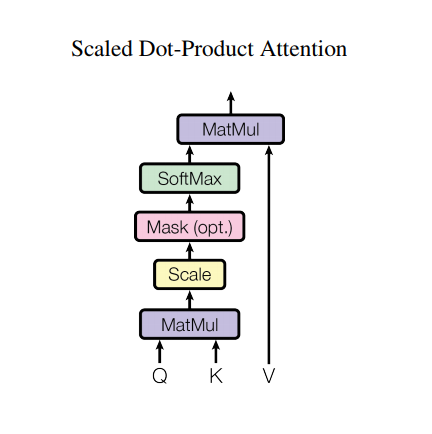  
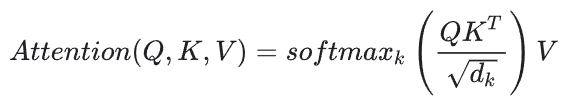

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

## Multi-head attention  
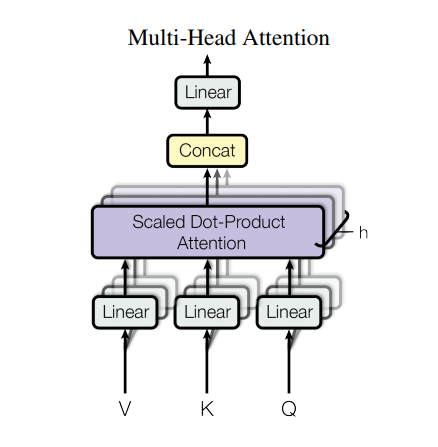

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

## Point wise feed forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and Decoder  
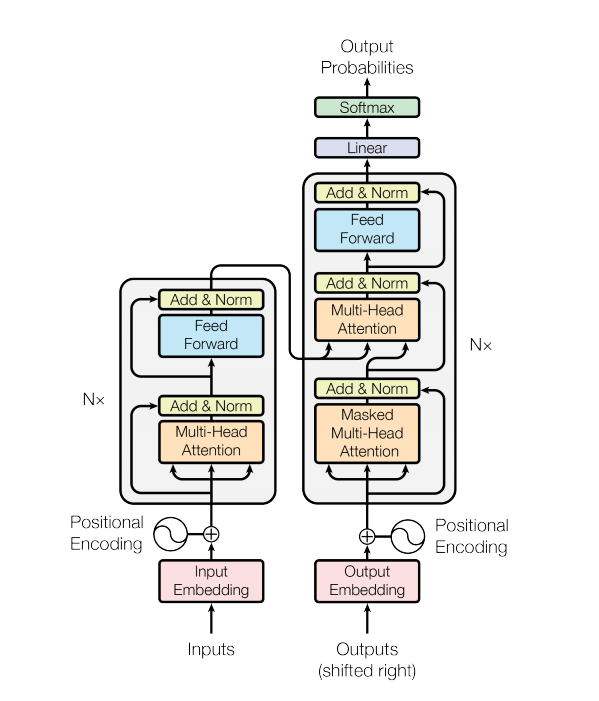

## EncoderLayer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

## Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

## Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

## Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

## hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer  
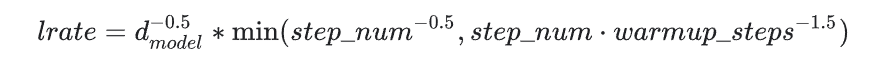

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(2048,warmup_steps=50000)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
learning_rate = CustomSchedule(d_model,warmup_steps=50000)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

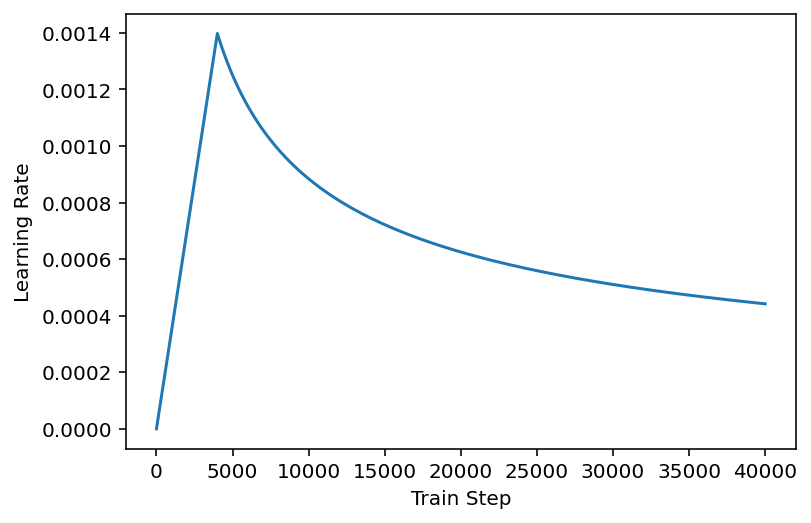

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss and metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ko_tokenizer.get_vocab_size(),
    target_vocab_size=en_tokenizer.get_vocab_size(),
    rate=dropout_rate)
EPOCHS = 20

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.114.24.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.24.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.124.32.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.32.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
with strategy.scope():
    learning_rate = CustomSchedule(d_model,warmup_steps=50000)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
    transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ko_tokenizer.get_vocab_size(),
    target_vocab_size=en_tokenizer.get_vocab_size(),
    rate=dropout_rate)
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function
def train_step(iterator):

    def step_fn(inputs):
        inp,tar = inputs
        tar_inp = tar[:,:-1]
        tar_real = tar[:,1:]

        with tf.GradientTape() as tape:
            predictions, _ = transformer([inp, tar_inp],
                                 training = True)
            loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss.update_state(loss)
        train_accuracy(accuracy_function(tar_real, predictions))
    strategy.run(step_fn, args=(next(iterator),))

In [ ]:
steps_per_epoch = int(160000 // BATCH_SIZE)
steps_per_eval = int(40000 // BATCH_SIZE)
train_iterator = iter(train_ds)

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  
  train_loss.reset_states()
  train_accuracy.reset_states()
  # inp -> portuguese, tar -> english
  for batch in range(steps_per_epoch):

      with strategy.scope():
          train_step(train_iterator)

      if batch % 50 == 0:
          print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')


TypeError: ignored

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_ds):

      with strategy.scope():
          train_step(inp, tar)

      if batch % 50 == 0:
          print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [ ]:
ko_test, en_test = next(train_iterator)

In [ ]:
en_test

(<tf.Tensor: shape=(149,), dtype=int64, numpy=
 array([   2, 2024,  825, 1984,  335,  149, 2460,   95,   73,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    

# Keras Model

In [104]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [105]:
vocab_size = 32003
sequence_length = 50

In [106]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

In [121]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


def build_model():
    embed_dim = 256
    latent_dim = 2048
    num_heads = 8
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
    x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
    transformer.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy() , metrics=tf.keras.metrics.SparseCategoricalAccuracy()
    )
    return transformer

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [122]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')

In [123]:
with strategy.scope():
    transformer = build_model()
history = transformer.fit(
        x= train_x,
        y= train_y,
        validation_data = [val_x, val_y],
        epochs=100,
        callbacks=[es],
        batch_size=256,
    )

Epoch 1/100
615/615 [==============================] - 90s 100ms/step - loss: 4.6988 - sparse_categorical_accuracy: 0.1563 - val_loss: 5.4702 - val_sparse_categorical_accuracy: 0.2127
Epoch 2/100
615/615 [==============================] - 38s 62ms/step - loss: 3.8129 - sparse_categorical_accuracy: 0.2385 - val_loss: 4.9168 - val_sparse_categorical_accuracy: 0.2511
Epoch 3/100
615/615 [==============================] - 38s 62ms/step - loss: 3.5315 - sparse_categorical_accuracy: 0.2631 - val_loss: 4.6115 - val_sparse_categorical_accuracy: 0.2732
Epoch 4/100
615/615 [==============================] - 38s 62ms/step - loss: 3.3561 - sparse_categorical_accuracy: 0.2788 - val_loss: 4.4247 - val_sparse_categorical_accuracy: 0.2859
Epoch 5/100
615/615 [==============================] - 38s 62ms/step - loss: 3.2204 - sparse_categorical_accuracy: 0.2916 - val_loss: 4.2643 - val_sparse_categorical_accuracy: 0.2977
Epoch 6/100
615/615 [==============================] - 38s 62ms/step - loss: 3.0988 

In [ ]:
en_tokenizer.get_vocab()

In [230]:
en_vocab = en_tokenizer.get_vocab()
en_index_to_word = {idx:word  for word,idx in en_vocab.items()}
max_decoded_sentence_length = 20

In [231]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = ko_tokenizer.encode(input_sentence).ids
    pad_input_sentence = tf.keras.preprocessing.sequence.pad_sequences([tokenized_input_sentence], maxlen=50,padding='post')
    decoded_sentence = "<s>"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = en_tokenizer.encode(decoded_sentence).ids
        pad_tokenized_target = tf.keras.preprocessing.sequence.pad_sequences([tokenized_target_sentence], maxlen=50, padding='post')
        predictions = transformer([pad_input_sentence, pad_tokenized_target])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = en_tokenizer.decode([sampled_token_index])
        decoded_sentence += " " + sampled_token

        if sampled_token == "</s>":
            break
    return decoded_sentence

In [232]:
decode_sequence("오바마 대통령")

'<s> President Obama President Obama president . </s>'

In [233]:
decode_sequence("시민들은 도시 속에 산다")

'<s> Citizens are busy citizens in the city . </s>'

In [234]:
decode_sequence("커피는 필요 없다")

'<s> It is not easy to do anything else . </s>'

In [235]:
decode_sequence("일곱 명의 사망자가 발생했다")

'<s> A few days after a death of a death . </s>'

In [236]:
decode_sequence("사건의 정황이 드러났다")

'<s> The case of this incident was revealed that the case was revealed . </s>'

In [237]:
decode_sequence("연말 연시 축제가 있다")

'<s> The global market is being held at the end of the year . </s>'

In [238]:
decode_sequence("구속 수사할 방침이다")

'<s> The prosecution plans to investigate investigate whether it will investigate arrest . </s>'

# 실험종료  

이번 트랜스포머에선 상당히 많은 시간이 소요되었는데, 전처리와 더불어 GPU 학습, 커스텀 루프 학습에 관한 이해도가 부족하여 상당한 시간이 소모되었다
다양한 학습을 시도하기 위해 인터넷에 나온 keras transformer 모델에 근거하여 tpu를 적용해서 사용하여 많은 학습률을 가진 상태에서 시도할 수 있었으나, 그럼에도 불구하고 val_loss, val_accuracy의 비율이 많이 높아 지진 못하였다
learning rate의 경우 기존 트랜스포머의 lr과, 1e-4를 비교하였는데 에포크가 많아질수록 스케쥴링 된 lr 비율이 급격하게 감소하여, 단순 고정 lr을 적용하였다
데이터는 기존의 데이터 말고 AIhub의 뉴스데이터를 활용하여 학습되었다
그렇다 보니 뉴스에 대한 내용을 타이핑 하면 비슷하게 번역이 되지만 뉴스에 나오지 않을 법한 단어를 적으면 예측하지 못하게 된다  
또한 max_length 길이 조절에 따른 이 길이를 채우기 위해 반복적인 단어가 드러나는 등의 문제점이 발견 되었다
따라서 정확도를 위해 더 많은 데이터가 필요할 것으로 보인다
이번 과정에서는 트랜스포머라는 모델이 비단 커스텀 루프 뿐만 아니라 keras 형태로도 짜일 수 있다는 것을 깨닫게 되었는데, 이게 가능하다는 건 keras의 형태를 구성하면 코드의 가독성도 좋아질 뿐더러 함수형 api의 형태를 사용함으로써 오류를 줄일 수 있게 때문에 상당히 유용하다는 사실을 알게 되었다. 또한 TPU 적용에 있어서도 유리하기 때문에 특히 학습시간에 시간을 많이 뺏기지 않아도 되는 점이 장점이다
기존 노드와 다르게 2~3일의 시간을 허비하게 되었지만 그만큼 많은 걸 배운 시간이었다